Data Analysis — CSO Dataset

**1.3. Apply different data pre-processing techniques e.g. data cleansing, data reshaping, and data preparation.**

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [2]:
#Upload file
uploaded = files.upload()

#get the uploaded filename automatically
filename = list(uploaded.keys())[0]

#load the CSV file into pandas
df = pd.read_csv(filename)
print("File name:",filename)

#display the 1st few rows
df.head()

Saving Dataset_Q1_149.csv to Dataset_Q1_149.csv
File name: Dataset_Q1_149.csv


,Statistic Label,Census Year,City of place of work,Electoral Divisions,UNIT,VALUE
0,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath",Ireland,Number,494383
1,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Agha, Carlow",Number,8
2,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballinacarrig, Carlow",Number,29
3,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballintemple, Carlow",Number,17
4,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballon, Carlow",Number,21


Checking data type, column name and missing column

In [3]:
print ("Dataset information:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nUnique column names:")
print(df.columns.tolist())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34210 entries, 0 to 34209
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Statistic Label        34210 non-null  object
 1   Census Year            34210 non-null  int64 
 2   City of place of work  34210 non-null  object
 3   Electoral Divisions    34210 non-null  object
 4   UNIT                   34210 non-null  object
 5   VALUE                  34210 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.6+ MB

Missing values per column:
Statistic Label          0
Census Year              0
City of place of work    0
Electoral Divisions      0
UNIT                     0
VALUE                    0
dtype: int64

Unique column names:
['Statistic Label', 'Census Year', 'City of place of work', 'Electoral Divisions', 'UNIT', 'VALUE']


Data Cleaning Observation
- The dataset consists of "34,210 rows" and "6 columns".  
- All columns have complete data with no missing values.  
- No further steps for handling missing values.

In [4]:
### Normalized column names

# Clean column names: lowercase, replace spaces and slashes with underscores
df.columns = [col.strip().lower().replace(" ", "_").replace("/", "_") for col in df.columns]

print("Normalized column names:")
print(df.columns.tolist())

# Display sample rows again
df.head()

#stripe whitespaces from the columns
for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].astype(str).str.strip()

print("Trimmed whitespaces")

df.head()

Normalized column names:
['statistic_label', 'census_year', 'city_of_place_of_work', 'electoral_divisions', 'unit', 'value']
Trimmed whitespaces


,statistic_label,census_year,city_of_place_of_work,electoral_divisions,unit,value
0,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath",Ireland,Number,494383
1,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Agha, Carlow",Number,8
2,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballinacarrig, Carlow",Number,29
3,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballintemple, Carlow",Number,17
4,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballon, Carlow",Number,21


Extract County from Electoral Division

In [5]:
import numpy as np
import re

def extract_county(ed_name):

    if pd.isna(ed_name):
        return np.nan

    # Split by commas and remove surrounding spaces
    parts = [p.strip() for p in str(ed_name).split(',') if p.strip()]

    if not parts:
        return np.nan

    last = parts[-1]

    # If the last part is numeric (ED code), skip to the previous one
    if re.fullmatch(r'\d+', last):
        if len(parts) >= 2:
            county = parts[-2]
        else:
            county = np.nan
    else:
        county = last

    # Remove 'Co', 'Co.' or 'County' prefixes if present
    county = re.sub(r'^(co\.?\s+|county\s+)', '', str(county), flags=re.IGNORECASE).strip()

    return county

# Apply function to the dataset
df['county'] = df['electoral_divisions'].apply(extract_county)

display(df[['electoral_divisions', 'county']].head(15))
print(df['county'].value_counts().head(10))

df.to_csv('Dataset_Q1_149.csv', index=False)

,electoral_divisions,county
0,Ireland,Ireland
1,"Agha, Carlow",Carlow
2,"Ballinacarrig, Carlow",Carlow
3,"Ballintemple, Carlow",Carlow
4,"Ballon, Carlow",Carlow
5,"Ballyellin, Carlow",Carlow
6,"Ballymoon, Carlow",Carlow
7,"Ballymurphy, Carlow",Carlow
8,"Borris, Carlow",Carlow
9,"Burton Hall, Carlow",Carlow


county
Cork County      3210
Galway County    2120
Tipperary        1750
Limerick         1720
Kerry            1640
Dublin City      1620
Clare            1510
Mayo             1510
Donegal          1490
Waterford        1290
Name: count, dtype: int64


In [6]:
print(df.columns.tolist())

['statistic_label', 'census_year', 'city_of_place_of_work', 'electoral_divisions', 'unit', 'value', 'county']


###**To remove national or aggregate summary rows (like “Ireland” or “All Ireland”) so they don’t distort county-level or regional analysis.**

In [7]:
#Create a True/False mask for rows whose electoral_divisions contain "ireland"
mask_total = df['electoral_divisions'].str.lower().str.contains("ireland", na=False)

#Count how many such rows there are
removed_rows = mask_total.sum()

#Keep only rows that are NOT aggregates
df_clean = df[~mask_total].copy()  # Keep only non-total rows

print(f"Removed {removed_rows} aggregate rows (e.g., 'Ireland').")
print("Cleaned dataset shape:", df_clean.shape)

df_clean[['electoral_divisions', 'county', 'value']].head(10)


Removed 10 aggregate rows (e.g., 'Ireland').
Cleaned dataset shape: (34200, 7)


,electoral_divisions,county,value
1,"Agha, Carlow",Carlow,8
2,"Ballinacarrig, Carlow",Carlow,29
3,"Ballintemple, Carlow",Carlow,17
4,"Ballon, Carlow",Carlow,21
5,"Ballyellin, Carlow",Carlow,0
6,"Ballymoon, Carlow",Carlow,8
7,"Ballymurphy, Carlow",Carlow,0
8,"Borris, Carlow",Carlow,8
9,"Burton Hall, Carlow",Carlow,19
10,"Carlow Rural, Carlow",Carlow,464


###**Missing values and duplicates check**

In [8]:
# Check for missing values again
print("Missing values per column after cleaning:")
print(df_clean.isnull().sum())

# Check for duplicate electoral divisions
dupes = df_clean.duplicated(subset=['electoral_divisions'], keep=False).sum()
print(f"Number of duplicate rows by 'electoral_divisions': {dupes}")

# Show summary stats for the numeric population column
print("\nSummary statistics for population values:")
print(df_clean['value'].describe())


Missing values per column after cleaning:
statistic_label          0
census_year              0
city_of_place_of_work    0
electoral_divisions      0
unit                     0
value                    0
county                   0
dtype: int64
Number of duplicate rows by 'electoral_divisions': 34200

Summary statistics for population values:
count    34200.000000
mean        22.230848
std        188.768973
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      11158.000000
Name: value, dtype: float64


Observation for Cell 8 — Missing Values, Duplicates, and Summary Statistics

- The dataset contains **34,200 rows and 7 columns** after cleaning.
- All columns (`statistic_label`, `census_year`, `city_of_place_of_work`, `electoral_divisions`, `unit`, `value`, `county`) have **0 missing values**, indicating a complete dataset.
- The duplicate check shows that **34,200 rows share the same `electoral_divisions` names**, which suggests that multiple records may exist for the same division due to additional classification fields such as `city_of_place_of_work`.
- Summary statistics of the `value` (population) column reveal a **highly skewed distribution**:
  - Mean population: **22.23**
  - Minimum: **0**, Maximum: **11,158**
  - Median (50th percentile): **0**
- This indicates that **most electoral divisions have very small or zero population values**, while a few divisions account for large population counts.
- Overall, the dataset is **complete and clean**, though duplicate divisions should be reviewed before detailed analysis.


In [9]:
# Save cleaned dataset for next steps
clean_filename = "Dataset_149_cleaned.csv"
df_clean.to_csv(clean_filename, index=False)

print(f"Saved cleaned dataset as {clean_filename}")

#download to local system
from google.colab import files
files.download(clean_filename)


Saved cleaned dataset as Dataset_149_cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**1.4. Perform exploratory data analysis by generating relevant summary statistics.**

In [10]:
#new runtime
if 'df_clean' not in globals():
  try:
    df_clean = pd.read_csv("Dataset_149_cleaned.csv")
    print("Loaded df_clean from Dataset_149_cleaned.csv")
  except Exception:
    raise RuntimeError("df_clean not found in memory. Run preprocessing cells or upload Dataset_149_cleaned.csv.")

print("df_clean shape:", df_clean.shape)
display(df_clean.head(3))

df_clean shape: (34200, 7)


,statistic_label,census_year,city_of_place_of_work,electoral_divisions,unit,value,county
1,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Agha, Carlow",Number,8,Carlow
2,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballinacarrig, Carlow",Number,29,Carlow
3,Population Usually Resident and Present in State,2022,"Dublin city and suburbs, Counties Dublin & Meath","Ballintemple, Carlow",Number,17,Carlow


In [11]:
# summary statistics and distribution checks
print("# summary for 'value' #")
display(df_clean['value'].describe())

print("Total rows:", len(df_clean))
if 'electoral_divisions' in df_clean.columns:
    print("Unique electoral divisions:", df_clean['electoral_divisions'].nunique())

# Show how many zero vs non-zero values
zeros = (df_clean['value'] == 0).sum()
nonzeros = (df_clean['value'] != 0).sum()
print(f"\nZero-value rows: {zeros}; Non-zero rows: {nonzeros} (proportion non-zero = {nonzeros/len(df_clean):.3f})")


# summary for 'value' #


,value
count,34200.000000
mean,22.230848
std,188.768973
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,11158.000000


Total rows: 34200
Unique electoral divisions: 3420

Zero-value rows: 29997; Non-zero rows: 4203 (proportion non-zero = 0.123)


Observation: Overall Summary Statistics

- The dataset contains **34,200 rows** representing population counts across **3,420 unique electoral divisions**.  
- The `value` variable (population count) is **highly skewed**, with an average of **22.23** people per record and a maximum of **11,158**.  
- The **first three quartiles (0, 0, 0)** indicate that 75 % of all records have zero population, while a small minority represent significant counts in larger urban divisions.  
- Approximately **12 % (4,203 rows)** record non-zero population values; the remaining 88 % are zero, suggesting empty or non-applicable divisions.  
- The duplication of electoral-division names (3,420 unique out of 34,200 rows) implies that each division is reported under multiple classifications, which will be addressed in county-level aggregation.


In [12]:
# Top 20 Electoral Divisions by population
# Shows the EDs with largest single reported 'value' (population).

if 'electoral_divisions' in df_clean.columns and 'value' in df_clean.columns:
    top_ed = df_clean.sort_values('value', ascending=False).head(20)[['electoral_divisions','county','value']]
    print("Top 20 Electoral Divisions by population (ED-level):")
    display(top_ed.reset_index(drop=True))
else:
    raise KeyError("Required columns ('electoral_divisions' and 'value') not found in df_clean.")


Top 20 Electoral Divisions by population (ED-level):


,electoral_divisions,county,value
0,"Blanchardstown-Blakestown, Fingal",Fingal,11158
1,"Lucan-Esker, South Dublin",South Dublin,9387
2,"Glencullen, Dún Laoghaire-Rathdown",Dún Laoghaire-Rathdown,7298
3,"Castleknock-Knockmaroon, Fingal",Fingal,5992
4,"Carrigaline/Monkstown Rural/Douglas, Cork City",Cork City,5875
5,"Ballincollig, Cork City",Cork City,5266
6,"Ballycummin, Limerick",Limerick,4796
7,"Lucan-St. Helens, South Dublin",South Dublin,4366
8,"Barna, Galway City",Galway City,4246
9,"Tallaght-Jobstown, South Dublin",South Dublin,4157


In [13]:
# Aggregate population by county
# Aggregates total, mean, median and ED count per county.
if 'county' in df_clean.columns and 'value' in df_clean.columns:
    county_agg = (df_clean
                  .groupby('county', dropna=True)['value']
                  .agg(total_population='sum', mean_population='mean', median_population='median', ed_count='count')
                  .reset_index()
                  .sort_values('total_population', ascending=False))
    print("County-level aggregated table (sorted by total_population):")
    display(county_agg.head(30))
else:
    raise KeyError("Required columns ('county' and 'value') not found in df_clean.")


County-level aggregated table (sorted by total_population):


,county,total_population,mean_population,median_population,ed_count
6,Dublin City,167762,103.556790,0.0,1620
25,South Dublin,79137,161.504082,0.0,490
8,Fingal,75725,180.297619,0.0,420
7,Dún Laoghaire-Rathdown,65669,95.172464,0.0,690
3,Cork City,58673,65.192222,0.0,900
4,Cork County,41569,12.949844,0.0,3210
16,Limerick,32013,18.612209,0.0,1720
12,Kildare,31422,35.305618,0.0,890
20,Meath,30005,32.614130,0.0,920
18,Louth,25630,56.955556,0.0,450


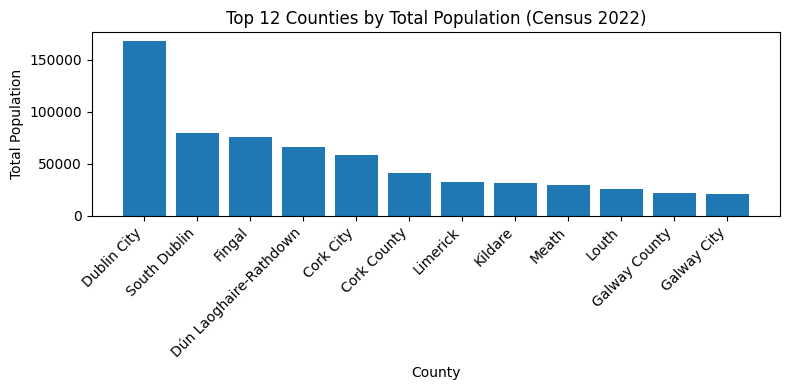

In [14]:
# Bar chart: Top 12 counties by total population
import matplotlib.pyplot as plt

if 'county_agg' in globals():
    topN = 12
    top_counties = county_agg.head(topN).copy()
    plt.figure(figsize=(8,4))
    plt.bar(top_counties['county'], top_counties['total_population'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {topN} Counties by Total Population (Census 2022)")
    plt.ylabel("Total Population")
    plt.xlabel("County")
    plt.tight_layout()
    plt.show()
else:
    print("county_agg not available.")


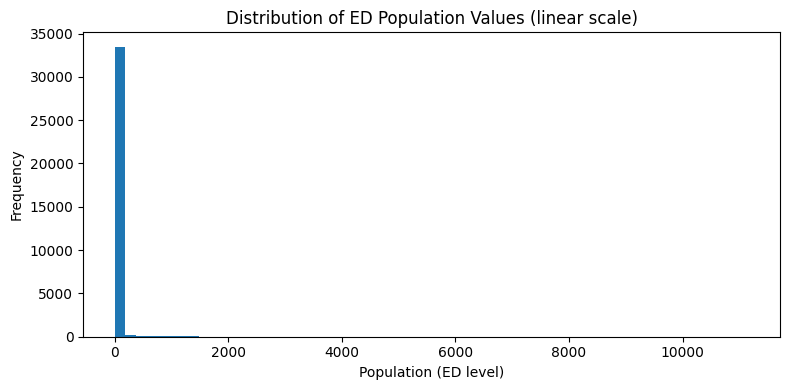

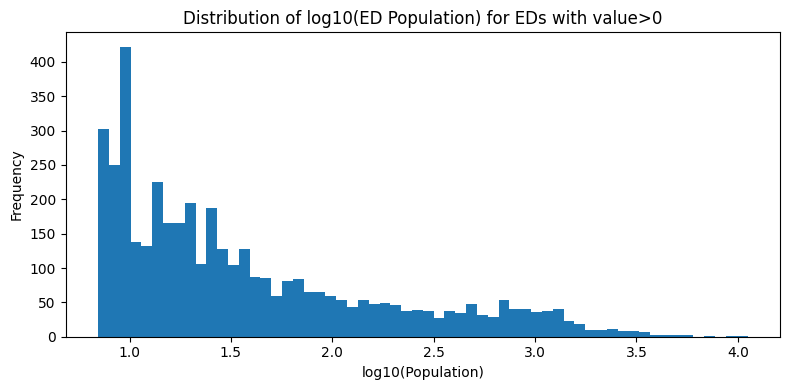

In [15]:
# Distribution of ED populations (histogram  and log-histogram)
vals = df_clean['value'].dropna()

# Linear histogram
plt.figure(figsize=(8,4))
plt.hist(vals, bins=60)
plt.title("Distribution of ED Population Values (linear scale)")
plt.xlabel("Population (ED level)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Log histogram
vals_pos = vals[vals>0]
if len(vals_pos) > 0:
    plt.figure(figsize=(8,4))
    plt.hist(np.log10(vals_pos), bins=60)
    plt.title("Distribution of log10(ED Population) for EDs with value>0")
    plt.xlabel("log10(Population)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("No positive 'value' entries to plot log-histogram.")


<Figure size 1000x600 with 0 Axes>

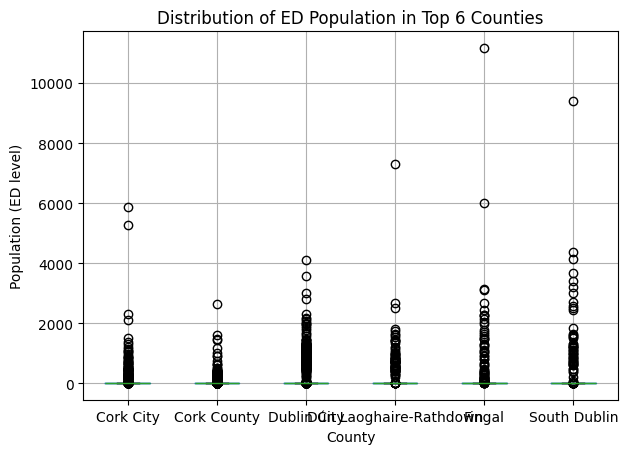

In [16]:

# Boxplot of ED population for top 6 counties

if 'county_agg' in globals():
    top6 = county_agg.head(6)['county'].tolist()
    df_top6 = df_clean[df_clean['county'].isin(top6)].copy()
    plt.figure(figsize=(10,6))
    df_top6.boxplot(column='value', by='county')
    plt.title("Distribution of ED Population in Top 6 Counties")
    plt.suptitle("")  # remove automatic subtitle
    plt.xlabel("County")
    plt.ylabel("Population (ED level)")
    plt.tight_layout()
    plt.show()
else:
    print("county_agg not available.")


,county,total_population,percent_share,cumulative_percent
6,Dublin City,167762,22.065383,22.065383
25,South Dublin,79137,10.408723,32.474105
8,Fingal,75725,9.959950,42.434055
7,Dún Laoghaire-Rathdown,65669,8.637305,51.071360
3,Cork City,58673,7.717136,58.788497
4,Cork County,41569,5.467483,64.255980
16,Limerick,32013,4.210602,68.466582
12,Kildare,31422,4.132869,72.599452
20,Meath,30005,3.946494,76.545946
18,Louth,25630,3.371060,79.917006


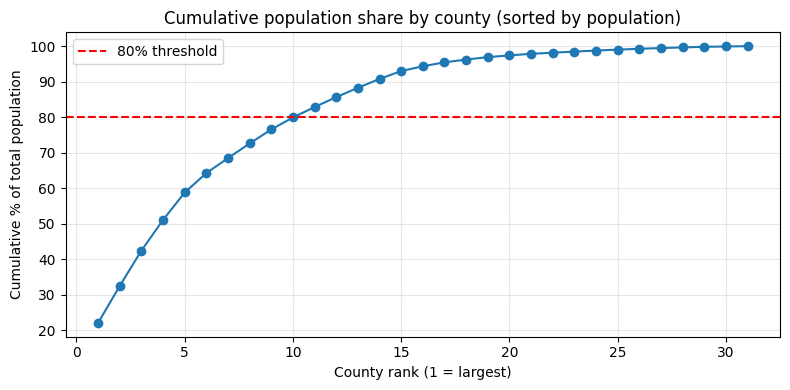

In [17]:
# County population share & cumulative percentage (Pareto-style)
if 'county_agg' in globals():
    county_share = county_agg[['county','total_population']].copy()
    county_share['percent_share'] = 100 * county_share['total_population'] / county_share['total_population'].sum()
    county_share['cumulative_percent'] = county_share['percent_share'].cumsum()
    display(county_share.head(30))

    # Plot cumulative share
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(county_share)+1), county_share['cumulative_percent'], marker='o')
    plt.axhline(80, color='red', linestyle='--', label='80% threshold')
    plt.title("Cumulative population share by county (sorted by population)")
    plt.xlabel("County rank (1 = largest)")
    plt.ylabel("Cumulative % of total population")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("county_agg not available.")


In [18]:
# Concise EDA findings

total_pop = int(df_clean['value'].sum())
n_counties = county_agg.shape[0] if 'county_agg' in globals() else df_clean['county'].nunique()
top1 = county_agg.iloc[0] if 'county_agg' in globals() else None

print("EDA Summary:")
print(f"- Total population (sum of 'value'): {total_pop:,}")
print(f"- Number of counties: {n_counties}")
if top1 is not None:
    print(f"- Most populous county: {top1['county']} with {int(top1['total_population']):,} residents")
print(f"- Median ED population (across records): {int(df_clean['value'].median())}")
print(f"- Proportion of EDs with zero population: {(df_clean['value']==0).mean():.3f}")


EDA Summary:
- Total population (sum of 'value'): 760,295
- Number of counties: 31
- Most populous county: Dublin City with 167,762 residents
- Median ED population (across records): 0
- Proportion of EDs with zero population: 0.877


**1.5 — Visualisations**

Top 10 Electoral Divisions by population (ED-level):


,electoral_divisions,county,value
0,"Blanchardstown-Blakestown, Fingal",Fingal,11158
1,"Lucan-Esker, South Dublin",South Dublin,9387
2,"Glencullen, Dún Laoghaire-Rathdown",Dún Laoghaire-Rathdown,7298
3,"Castleknock-Knockmaroon, Fingal",Fingal,5992
4,"Carrigaline/Monkstown Rural/Douglas, Cork City",Cork City,5875
5,"Ballincollig, Cork City",Cork City,5266
6,"Ballycummin, Limerick",Limerick,4796
7,"Lucan-St. Helens, South Dublin",South Dublin,4366
8,"Barna, Galway City",Galway City,4246
9,"Tallaght-Jobstown, South Dublin",South Dublin,4157


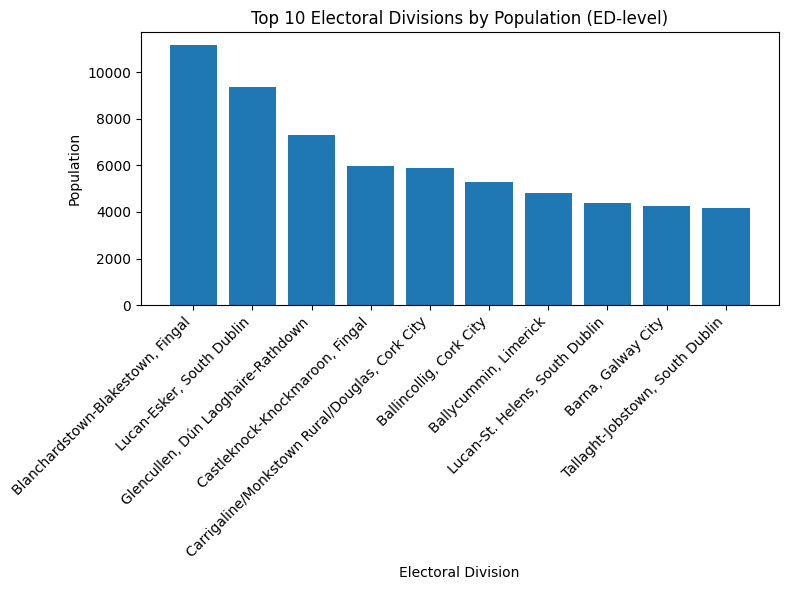

In [19]:

# Top 10 Electoral Divisions (table + bar chart)
# Create top_ed from df_clean (ED-level) and plot it
top_ed = df_clean.sort_values('value', ascending=False).head(10)[['electoral_divisions','county','value']].reset_index(drop=True)
print("Top 10 Electoral Divisions by population (ED-level):")
display(top_ed)

# Bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.bar(top_ed['electoral_divisions'].astype(str), top_ed['value'])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Electoral Divisions by Population (ED-level)")
plt.ylabel("Population")
plt.xlabel("Electoral Division")
plt.tight_layout()
plt.show()


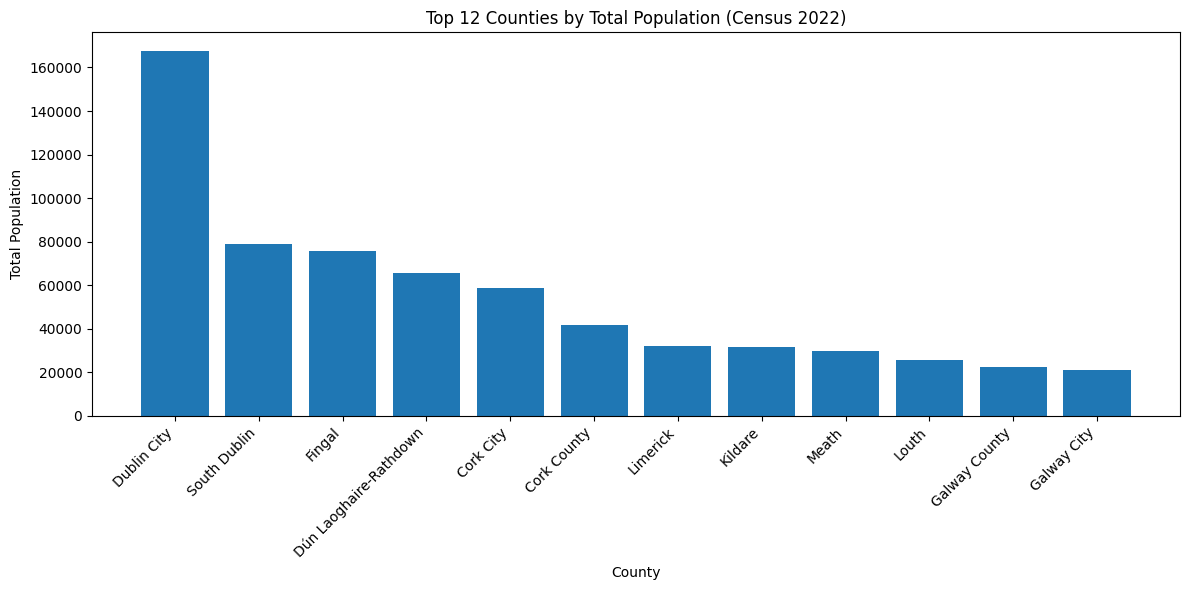

In [20]:

# Top N counties bar chart (uses existing county_agg)

# Use the county_agg you computed in 1.4
topN = 12
if 'county_agg' not in globals():
    raise NameError("county_agg not found. Please run 1.4 county aggregation first.")
top_counties = county_agg.head(topN).copy()

plt.figure(figsize=(8,6))
plt.bar(top_counties['county'], top_counties['total_population'])
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {topN} Counties by Total Population (Census 2022)")
plt.ylabel("Total Population")
plt.xlabel("County")
plt.tight_layout()
plt.show()


County cumulative shares (top rows):


,county,total_population,percent_share,cumulative_percent
6,Dublin City,167762,22.065383,22.065383
25,South Dublin,79137,10.408723,32.474105
8,Fingal,75725,9.959950,42.434055
7,Dún Laoghaire-Rathdown,65669,8.637305,51.071360
3,Cork City,58673,7.717136,58.788497
4,Cork County,41569,5.467483,64.255980
16,Limerick,32013,4.210602,68.466582
12,Kildare,31422,4.132869,72.599452
20,Meath,30005,3.946494,76.545946
18,Louth,25630,3.371060,79.917006


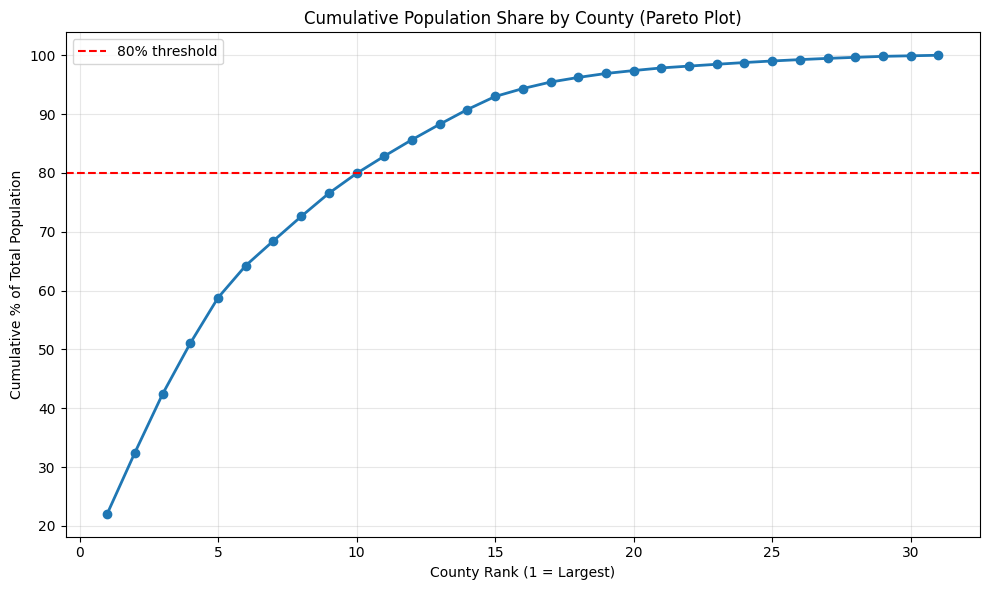

In [21]:

# Pareto / cumulative share plot of counties

# Build county_share from county_agg
county_share = county_agg[['county','total_population']].copy()
total_sum = county_share['total_population'].sum()
county_share['percent_share'] = 100 * county_share['total_population'] / total_sum
county_share['cumulative_percent'] = county_share['percent_share'].cumsum()

print("County cumulative shares (top rows):")
display(county_share.head(15))

plt.figure(figsize=(8,6))
plt.plot(range(1, len(county_share)+1), county_share['cumulative_percent'], marker='o', linewidth=2)
plt.axhline(80, color='red', linestyle='--', label='80% threshold')
plt.title("Cumulative Population Share by County (Pareto Plot)")
plt.xlabel("County Rank (1 = Largest)")
plt.ylabel("Cumulative % of Total Population")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


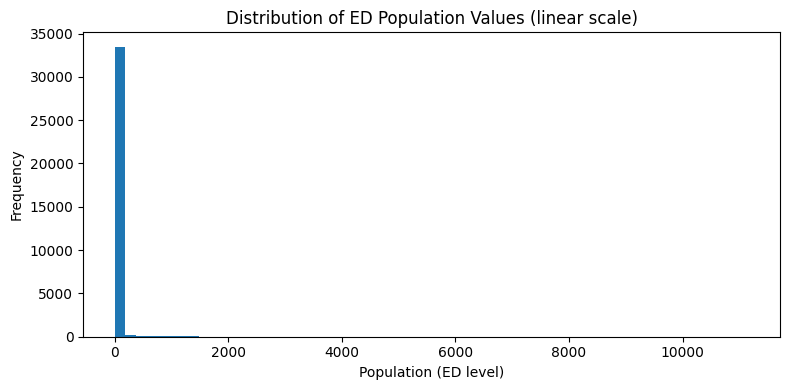

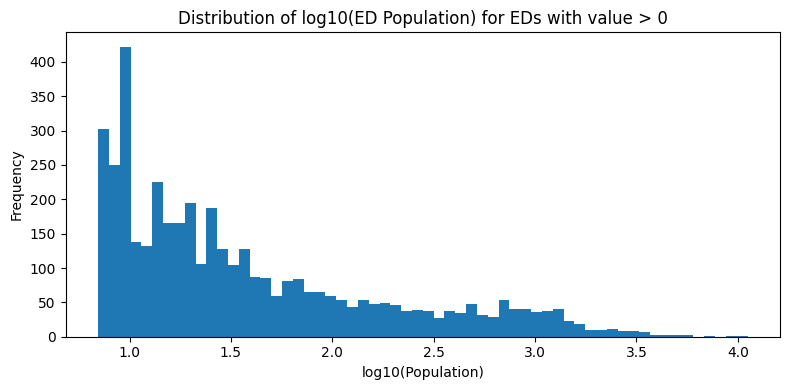

In [22]:
# Histogram & log-histogram of ED population values

vals = df_clean['value'].dropna()

# Linear histogram
plt.figure(figsize=(8,4))
plt.hist(vals, bins=60)
plt.title("Distribution of ED Population Values (linear scale)")
plt.xlabel("Population (ED level)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Log histogram (only positives)
vals_pos = vals[vals > 0]
if len(vals_pos) > 0:
    plt.figure(figsize=(8,4))
    plt.hist(np.log10(vals_pos), bins=60)
    plt.title("Distribution of log10(ED Population) for EDs with value > 0")
    plt.xlabel("log10(Population)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("No positive ED population values to plot log-histogram.")


<Figure size 1200x600 with 0 Axes>

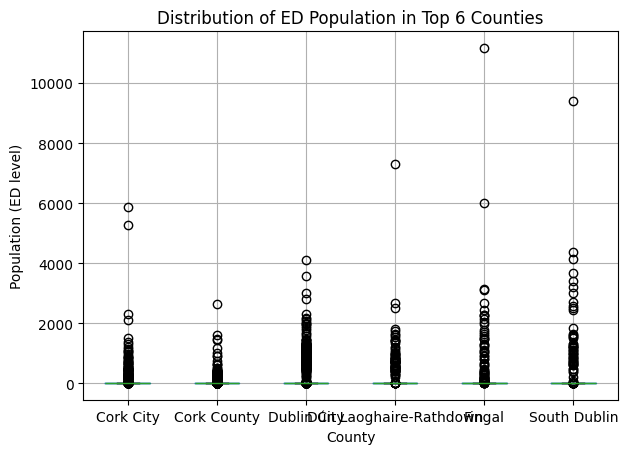

In [23]:
# Boxplot: ED population spread for top K counties
K = 6
topK = county_agg.head(K)['county'].tolist()
df_topK = df_clean[df_clean['county'].isin(topK)].copy()

if df_topK.empty:
    print("No rows found for top counties — check 'county' values.")
else:
    # ensure value column named 'value' for plotting convenience
    df_topK_plot = df_topK.rename(columns={'value':'value_plot'}) if 'value' not in df_topK.columns else df_topK
    plt.figure(figsize=(12,6))
    df_topK.boxplot(column='value', by='county')
    plt.suptitle('')
    plt.title(f'Distribution of ED Population in Top {K} Counties')
    plt.xlabel('County')
    plt.ylabel('Population (ED level)')
    plt.tight_layout()
    plt.show()


In [24]:
# Urban/Rural classification and sensitivity table (three methods)

# Method A: county-list (conservative)
urban_counties = set(['Dublin','Cork','Galway','Limerick','Waterford'])
df_clean['county_norm'] = df_clean['county'].astype(str).str.strip().str.title().replace({'Nan': pd.NA})
df_clean['is_urban_county'] = df_clean['county_norm'].apply(lambda x: True if pd.notna(x) and x in urban_counties else False)
urban_pop_county = df_clean[df_clean['is_urban_county']]['value'].sum()

# Method B: top-N counties by aggregated population (data-driven)
N = 5
topN_list = county_agg.head(N)['county'].tolist()
df_clean['is_urban_topN'] = df_clean['county'].isin(topN_list)
urban_pop_topN = df_clean[df_clean['is_urban_topN']]['value'].sum()

# Method C: threshold-based ED classification
thresholds = [500,1000,1500,2000]
th_results = []
total_pop = df_clean['value'].sum()
for th in thresholds:
    col = f'is_urban_th_{th}'
    df_clean[col] = df_clean['value'] >= th
    upop = df_clean[df_clean[col]]['value'].sum()
    th_results.append({'threshold': th, 'urban_pop': int(upop), 'urban_share': upop/total_pop if total_pop>0 else np.nan})

# Build summary DF (sensitivity_df)
summary_rows = [
    {'method':'county_list', 'urban_pop':int(urban_pop_county), 'urban_share': urban_pop_county/total_pop if total_pop>0 else np.nan},
    {'method':f'top{N}_counties', 'urban_pop':int(urban_pop_topN), 'urban_share': urban_pop_topN/total_pop if total_pop>0 else np.nan}
]
for r in th_results:
    summary_rows.append({'method':f"th_{r['threshold']}", 'urban_pop': r['urban_pop'], 'urban_share': r['urban_share']})

sensitivity_df = pd.DataFrame(summary_rows)
print("Urban/rural sensitivity summary:")
display(sensitivity_df)


Urban/rural sensitivity summary:


,method,urban_pop,urban_share
0,county_list,51083,0.067188
1,top5_counties,446966,0.587885
2,th_500,550933,0.724631
3,th_1000,390505,0.513623
4,th_1500,243852,0.320733
5,th_2000,185882,0.244487


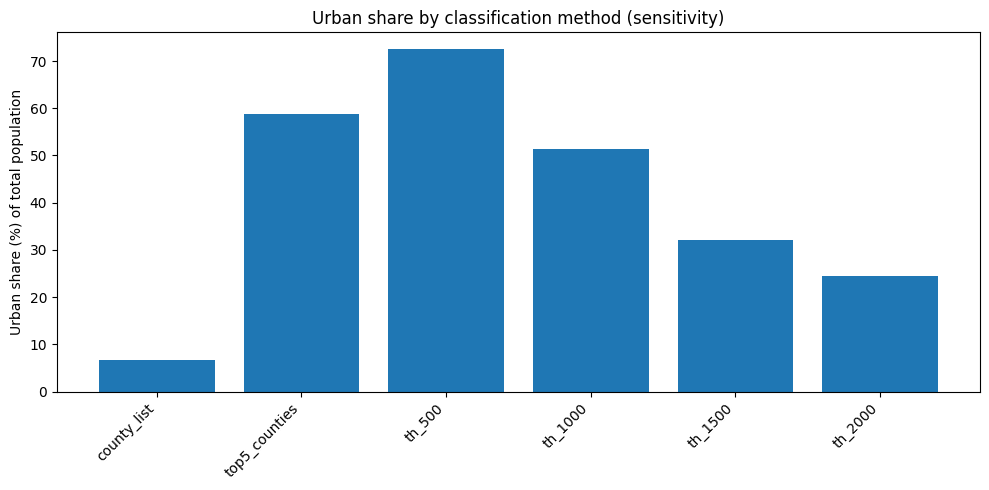

Saved sensitivity table: urban_classification_sensitivity.csv


In [25]:

# Visualize sensitivity: urban share (%) by method

sensitivity_df['urban_share_pct'] = sensitivity_df['urban_share'] * 100
plt.figure(figsize=(10,5))
plt.bar(sensitivity_df['method'], sensitivity_df['urban_share_pct'])
plt.ylabel('Urban share (%) of total population')
plt.title('Urban share by classification method (sensitivity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Save sensitivity table for report
sensitivity_df.to_csv("urban_classification_sensitivity.csv", index=False)
print("Saved sensitivity table: urban_classification_sensitivity.csv")


**1.6 Visualise dataset on geographical area**

In [26]:
# Upload geojson file
from google.colab import files
uploaded = files.upload()

# After upload, list the uploaded filenames
print("Uploaded files:", list(uploaded.keys()))


Saving Counties___OSi_National_Statutory_Boundaries_1239634581601351404.geojson to Counties___OSi_National_Statutory_Boundaries_1239634581601351404.geojson
Uploaded files: ['Counties___OSi_National_Statutory_Boundaries_1239634581601351404.geojson']


In [27]:
import os
import json
import folium
from folium import Choropleth, GeoJson, Popup, CircleMarker
from IPython.display import display

try:
    county_agg
    print("Using county_agg from memory. Shape:", county_agg.shape)
except NameError:
    # Try to recreate from df_clean
    try:
        county_agg = df_clean.groupby('county', dropna=True)['value'].sum().reset_index().rename(columns={'value':'total_population'}).sort_values('total_population', ascending=False)
        print("Recreated county_agg from df_clean. Shape:", county_agg.shape)
    except Exception as e:
        raise RuntimeError("county_agg not found and could not be recreated.") from e

# Find a geojson file if present
geo_candidate = None
for fname in os.listdir('.'):
    if fname.lower().endswith('.geojson') or fname.lower().endswith('.json'):
        geo_candidate = fname
        break

if geo_candidate:
    print("Found GeoJSON file:", geo_candidate)
    with open(geo_candidate, "r", encoding="utf-8") as f:
        gj = json.load(f)
    print("GeoJSON loaded successfully!")
    print("Number of county features:", len(gj["features"]))
else:
    print("No GeoJSON detected in working directory")


Using county_agg from memory. Shape: (31, 5)
Found GeoJSON file: Counties___OSi_National_Statutory_Boundaries_1239634581601351404.geojson
GeoJSON loaded successfully!
Number of county features: 31


GeoJSON loaded successfully!
Columns available in GeoDataFrame: ['ENGLISH', 'GAEILGE', 'CONTAE', 'COUNTY', 'PROVINCE', 'GUID', 'CENTROID_X', 'CENTROID_Y', 'AREA', 'CC_ID', 'ESRI_OID', 'geometry']


<Figure size 1000x1000 with 0 Axes>

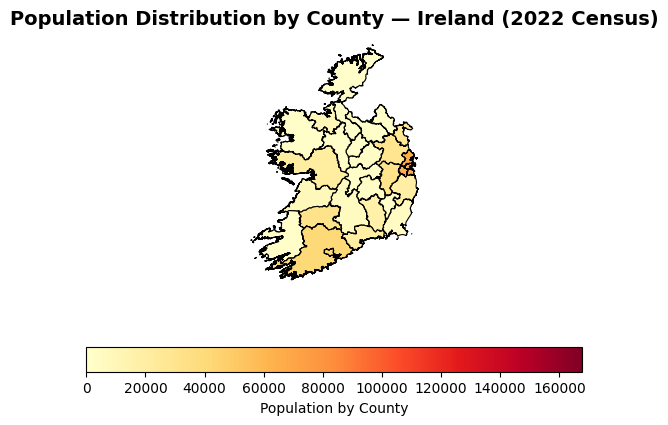

Static map saved as 'Ireland_Population_Map_Static.png'


<Figure size 640x480 with 0 Axes>

In [33]:
# Static map using GeoPandas + Matplotlib

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import re

# Load the GeoJSON file (Ireland counties)
geo_filename = "Counties___OSi_National_Statutory_Boundaries_1239634581601351404.geojson"
gdf = gpd.read_file(geo_filename)

print("GeoJSON loaded successfully!")
print("Columns available in GeoDataFrame:", gdf.columns.tolist())

# Clean and prepare the county data
def simple_clean(s):
    if pd.isna(s):
        return ""
    s = str(s).strip().lower()
    s = re.sub(r'\b(city|county|co\.?|co)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[^a-z\s]', '', s)
    return s.strip().upper()

county_agg['county_clean'] = county_agg['county'].apply(simple_clean)

# Merge Dublin sub-counties (if any)
county_agg['county_clean'] = county_agg['county_clean'].replace({
    'DN LAOGHAIRERATHDOWN': 'DUBLIN',
    'FINGAL': 'DUBLIN',
    'SOUTH DUBLIN': 'DUBLIN'
})

# Merge your population data with the GeoDataFrame
merged = gdf.merge(county_agg, how='left', left_on='COUNTY', right_on='county_clean')

# Plot the static choropleth
plt.figure(figsize=(10, 10))
merged.plot(
    column='total_population',
    cmap='YlOrRd',          # yellow → orange → red color scale
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Population by County", 'orientation': "horizontal"},
    vmin=0, vmax=merged['total_population'].max()
)

plt.title("Population Distribution by County — Ireland (2022 Census)", fontsize=14, fontweight='bold')
plt.axis('off')  # Hide axis lines
plt.show()

# Optional: Save the figure
plt.savefig("Ireland_Population_Map_Static.png", dpi=300, bbox_inches='tight')
print("Static map saved as 'Ireland_Population_Map_Static.png'")
